# Problème inverse : Assignation de données

On considère l'équation de la chaleur stationnaire avec terme source dans un domaine $\Omega = [0 , L] \times [0 , H]$ :

$$
\left\{
    \begin{array}{ll}
        \Delta u = f & \text{dans } \Omega \\
        u = 0 & \text{sur } \partial \Omega
    \end{array}
\right.
$$
    
et alors
$(u, f) \in V = \left\{ u \in H^1_0(\Omega), f \in L^2(\Omega) \; \big\lvert \; \Delta u = f \right\}.$
    
On considère $N$ points $(x_i, y_i) \in \Omega$ où la température $T_i$ est fixée (mesurée).

On cherche à minimiser la quantité:

$$
I = \sum_{i=1}^N \left( u(x_i, y_i) - T_i \right)^2
$$

sur $(u, f) \in V$ pour reconstruire la solution $u$ à partir des $T_i$.

# Equation de la chaleur par différences finies 2D

Dans un premier temps, il faut simuler l'équation de la chaleur stationnaire 2D par différences finies sur une grille cartésienne afin de se pouvoir calculer $T_i$.

On se donne le maillage suivant:

![Maillage en espace ($(i,j) \in [0,n_x + 1] \times [0,n_y + 1]$ et $[x_0,x_{n_x + 1}] \times [y_0,y_{n_y + 1}] = [0;L_x] \times [0;L_y]$)](mesh.png)

Maillage en espace ($(i,j) \in [0,n_x + 1] \times [0,n_y + 1]$ et $[x_0,x_{n_x + 1}] \times [y_0,y_{n_y + 1}] = [0;L_x] \times [0;L_y]$)

On approche l'équation $\Delta u = f$ par le schéma suivant:

$$
\frac{2 u_{i,j} - u_{i+1,j} - u_{i-1,j}}{\Delta x^2} + \frac{2 u_{i,j} - u_{i,j+1} - u_{i,j-1}}{\Delta y^2} = f_{i,j}
$$

Afin de pouvoir écrire ce schéma sous forme matricielle on va changer la numérotation des indices en posant 

$k = i - 1 + n_x (j-1)$, soit $u_{k} = u_{i,j}$.

On retombe sur $i$ et $j$ avec $i = k \% n_x  + 1$ et $j = (k - i + 1) // n_x + 1$ (le reste et la partie entière de $k$ par $n_x$).On obtient donc le nouveau schéma:

$$
    \frac{2 u_{k} - u_{k+1} - u_{k-1}}{\Delta x^2} + \frac{2 u_{k} - u_{k+n_x} - u_{k-n_x}}{\Delta y^2} = f_{k}
$$

On peux donc écrire le schéma sous forme matricielle (sans considérer les bords):

$$
    A U = b
$$

où $U = (u_{k})_{k \in I}$ ($I = [0, n_x n_y - 1]$), $b = (f_{k})_{k \in I}$ et la matrice $A = a_{kl}$ la matrice du laplacien 2D:

$$
a_{kl} =
\begin{cases}
\frac{2}{\Delta x^2} + \frac{2}{\Delta y^2}, & \text{si } k = l \\
\frac{-1}{\Delta x^2}, & \text{si } i = j - 1 \text{ ou } k = l + 1\\
\frac{-1}{\Delta y^2}, & \text{si } i = j - n_x \text{ ou } k = l + n_x\\
0, & \text{sinon}
\end{cases}
$$


## Solveur utilisé : Gradient Conjugué

### Algo:

$k = 0$,\
$r_k = b - A x_0$,\
$p=r_k$

**Tant que** ($ \|r_k\| > \epsilon$) et ($k \leq k_{max}$)  **faire**

$z = Ap$,\
$\alpha = \frac{<r_k,r_k>}{<z,p>}$,\
$x=x-\alpha p$,\
$r_{k+1} = r_k - \alpha z$,\
$\gamma = \frac{<r_{k+1},r_{k+1}>}{<r_{k}, r_{k}>}$,\
$p = r_{k+1} + \gamma p$,\
$k=k+1$,

**Fin Tant Que**

**Retourner** k, x

# Fonction *heat* pour simuler l'équation de la chaleur stationnaire

In [87]:
import numpy  as np
import time
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags
import scipy.linalg as sp

def heat(nx, ny, u0, f, L=1, H=1):
    """ Fonction simulant l'équation de la chaleur stationnaire 2D sur un maillage cartésien uniforme par différences finies
    avec des conditions aux limites de type Dirichlet homogène. Arguments :
        - nx : nombre de mailles selon x
        - ny : nombre de mailles selon y
        - u0 : solution initiale (scalaire)
        - f : terme source (fonction prenant 2 scalaires (x, y) en entrée pour retourner un scalaire f(x, y))
        - L : longueur du domaine (= 1 par défaut)
        - H : hauteur du domaine (= 1 par défaut)
        - max_iter : nombre maximal d'itérations pour le gradient conjugué (= 10000 par défaut)
        - epsilon : seuil d'erreur minimal pour le gradient conjugué (= 1e-7 par défaut) """

       # Construction du maillage : liste P des points P(i,j) = (x(i), y(j)) 
    # du maillage indexés par k = i - 1 + nx * (j - 1)
    N = nx * ny
    dx = L / (nx+1)
    dy = H / (ny+1)
    P = np.array([[[i * dx, j * dy] for i in range(1, nx + 1)] for j in range(1, ny + 1)]) 
    P = P.reshape(N, 2)

    # Construction du système linéaire Au = b
    
    N = nx * ny
    alpha = - 2 * (1 / dx**2 + 1 / dy**2) * np.ones(N) # Diagonale de A
    beta = np.ones(N - 1) / dx ** 2 # Diagonales décalées de 1 indice
    beta[nx - 1::nx] = 0 # Brisures de la diagonale
    gamma = np.ones(N - nx) / dy ** 2 # Diagonale décalée de nx indices
    k = [gamma, beta, alpha, beta, gamma]
    offset = [-nx, -1, 0, 1, nx]
    A = diags(k, offset).toarray() # Matrice A
    b = np.array([f(P[k, 0], P[k, 1]) for k in range(N)]) # Second membre b

    # Résolution du système linéaire
    c, low_bool = sp.cho_factor(-A, lower=True)
    u = -sp.cho_solve((c, low_bool), b)
    print(c)

    u2D = u.reshape(ny, nx)
    u = np.zeros((nx+2, ny+2))
    u[1:-1, 1:-1] = u2D.T

    
    return u, A, b

# Test de la fonction *heat*

In [48]:
# Définition du terme source

def TS(x,y):
    
    return np.cos(x) + np.sin(y)

# Définition des paramètres

Nx = 20
Ny = 20
H = 7
L = 7

# Résolution du problème

T = heat(Nx, Ny, 0, TS, H=H, L=L)[0]

# Affichage du résultat

plt.imshow(T, origin='lower', cmap='jet', extent=[0, L, 0, H])
cbar = plt.colorbar() 
cbar.set_label('T')

plt.xlabel('x')  # Légende de l'axe X
plt.ylabel('y')  # Légende de l'axe Y
plt.title(r'Solution de $\Delta T(x,y) = TS(x,y)$')  # Titre du graphique

plt.show()


TypeError: 'int' object is not callable

# Vérification 

On choisit ici la solution pour la solution exacte :

$$
u_{exact}(x,y) = \frac{1}{LH} x \cdot y \cdot (L - x) \cdot (H - y)
$$

qui respecte bien les conditions de dirichlet imposées aux bords.

On calcul le terme source associé $f_{exact} = \frac{\partial^2 u_{exact}}{\partial x^2} + \frac{\partial^2 u_{exact}}{\partial y^2}$ :

$$
u_{exact}(x,y) =\frac{1}{LH}(LHxy - Hx^2y - Lxy^2 + x^2 y^2)
$$

On en déduit donc :

$$
f_{exact}(x,y) = \frac{1}{LH} (- 2Hy + 2y^2 - 2Lx + 2x^2)
$$

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Définition des paramètres

Nx = 20
Ny = 20
H = 7
L = 7

dx = L / (Nx+1)
dy = H / (Ny+1)

# Définition du terme source

def TS(x,y):
    
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème

T, (c, low_bool) = heat(Nx, Ny, TS, decomp=True, L=L, H=H)

# Vérification

def u_exact(x,y):
    return x*y*(L-x)*(H-y) / (L * H)

# Calcul de la solution exacte
U_exact = np.zeros((Nx+1)*(Ny+1))
for j in range(1,Ny+1):
    for i in range(1,Nx+1):
        U_exact[i-1+(j-1)*Nx] = u_exact(i * dx, j * dy)
U_exact = U_exact.reshape(Ny, Nx).T # Remise sous forme de matrice

# Calcul de la différence
diff = np.abs(T - U_exact)

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5)) # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 1)
plt.imshow(T, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution exacte
plt.subplot(1, 3, 2)
plt.imshow(U_exact, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='T exact')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Exacte')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='Différence')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue')

plt.tight_layout()
plt.show()

ValueError: cannot reshape array of size 441 into shape (20,20)

# Equation des sensibilités

Nombre d'itérations du gradient conjugué:  178
Résidu du gradient conjugué:  8.958498629696441e-08
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0047088  0.00932343 ... 0.00932343 0.0047088  0.        ]
 [0.         0.00932343 0.01846039 ... 0.01846039 0.00932343 0.        ]
 ...
 [0.         0.00932343 0.01846039 ... 0.01846039 0.00932343 0.        ]
 [0.         0.0047088  0.00932343 ... 0.00932343 0.0047088  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


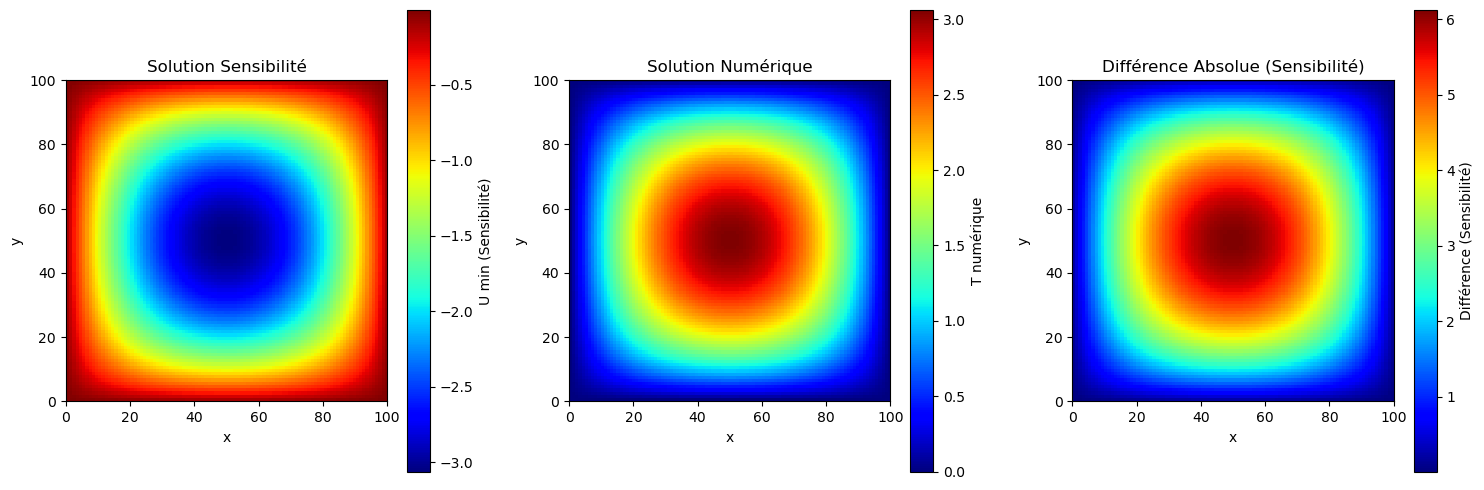

In [13]:
import numpy  as np
import time
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags

# Définition des paramètres

Nx = 100
Ny = 100
H = 7
L = 7

# Définition du terme source

def TS(x,y):
    
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème
H = heat(Nx, Ny, 0, TS, H=H, L=L, epsilon=1e-7)

T = H[3]
A = H[1]
F = H[2]
Q = H[0]
print(Q)
# Fonction de sensibilité pour le minimum
def SensitivityMethod(T, A, F):
    # Calcul de la sensibilité
    S = A.transpose().dot(np.linalg.inv(A.dot(A.transpose())))

    # Calcul du gradient de la fonction coût
    grad_J = A.dot(T.flatten()) - F

    # Calcul de la direction de descente
    d = -S.dot(grad_J)

    # Mise à jour de la solution
    U = T.flatten() + d
    U = U.reshape(T.shape)

    return U

# Solution par la méthode de sensibilité pour le minimum
U_sensitivity = SensitivityMethod(T, A, F)

# Calcul de la différence
diff_sensitivity = np.abs(U_sensitivity - T)

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5))  # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 2)
plt.imshow(Q, origin='lower', cmap='jet', extent=[0, len(T[0]), 0, len(T)])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution de la méthode de sensibilité
plt.subplot(1, 3, 1)
plt.imshow(U_sensitivity, origin='lower', cmap='jet', extent=[0, len(U_sensitivity[0]), 0, len(U_sensitivity)])
plt.colorbar(label='U min (Sensibilité)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Sensibilité')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff_sensitivity, origin='lower', cmap='jet', extent=[0, len(diff_sensitivity[0]), 0, len(diff_sensitivity)])
plt.colorbar(label='Différence (Sensibilité)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue (Sensibilité)')

plt.tight_layout()
plt.show()


# Equation adjointes

3.0486268581506675
[ 0.         -0.28571429  0.04081633  0.         -0.28571429  0.04081633]
gradNorm = 0 30848.08587585684
gradNorm = 4000 157.63683813349735
gradNorm = 8000 124.14972745567347
gradNorm = 12000 97.77711940693273
gradNorm = 16000 77.00770637076774
gradNorm = 20000 60.65127622749568
gradNorm = 24000 47.77050602147943
gradNorm = 28000 37.6272475907118
gradNorm = 32000 29.640226959766043
gradNorm = 36000 23.351733329472232
gradNorm = 40000 18.40138856778551
gradNorm = 44000 14.505493690975033
gradNorm = 48000 11.440768083420231
[-0.12467256 -0.18730708  0.02582574 -0.12467256 -0.18744633  0.02585697]


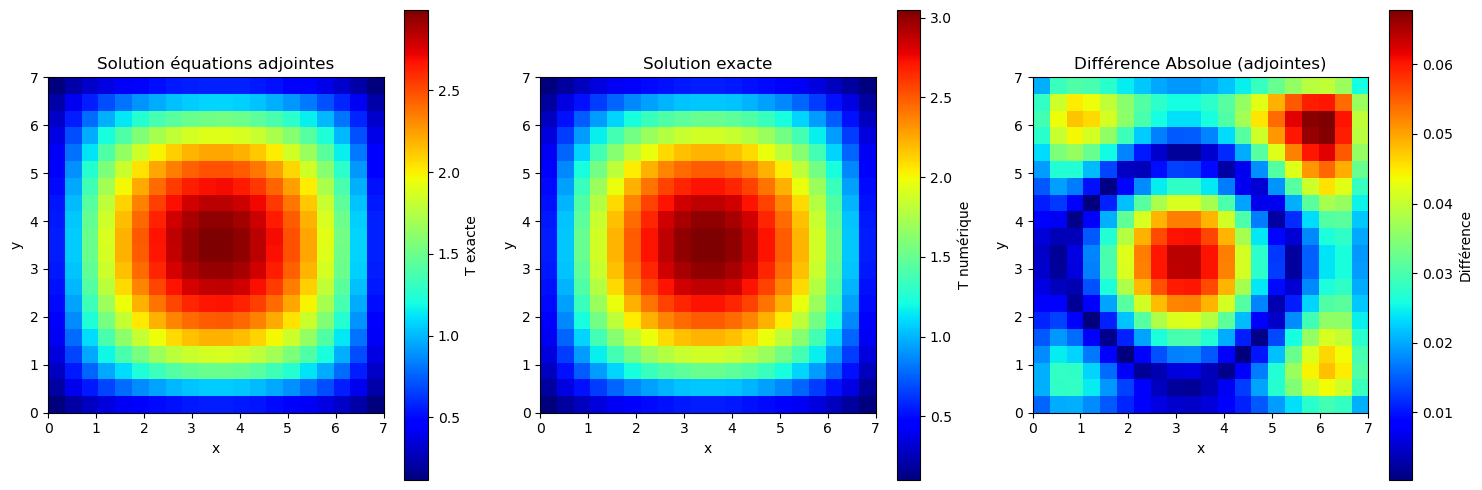

In [45]:
import numpy  as np
import time
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags
import scipy.linalg as sp
from functools import partial

# Définition des paramètres

Nx = 20
Ny = 20
H = 7
L = 7
dx = L / (Nx+1)
dy = H / (Ny+1)

def u_exact(x,y):
    return x*y*(L-x)*(H-y) / (L * H)

# En 1 : appeler heat pour calculer u
def heat(nx, ny, f, c=0, low_bool=0,  decomp=False, L=1, H=1):
    """ Fonction simulant l'équation de la chaleur stationnaire 2D sur un maillage cartésien uniforme par différences finies
    avec des conditions aux limites de type Dirichlet homogène. Arguments :
        - nx : nombre de mailles selon x
        - ny : nombre de mailles selon y
        - u0 : solution initiale (scalaire)
        - f : terme source (fonction prenant 2 scalaires (x, y) en entrée pour retourner un scalaire f(x, y))
        - L : longueur du domaine (= 1 par défaut)
        - H : hauteur du domaine (= 1 par défaut)
        - max_iter : nombre maximal d'itérations pour le gradient conjugué (= 10000 par défaut)
        - epsilon : seuil d'erreur minimal pour le gradient conjugué (= 1e-7 par défaut) """

       # Construction du maillage : liste P des points P(i,j) = (x(i), y(j)) 
    # du maillage indexés par k = i - 1 + nx * (j - 1)
    N = nx * ny
    dx = L / (nx+1)
    dy = H / (ny+1)

    # Construction du système linéaire Au = b
    
    N = nx * ny
    b = np.zeros(nx*ny) # Second membre b
    for I in range(nx * ny):
        i = I % nx + 1
        j = I // nx + 1
        b[i-1 + (j-1)*nx] = f(i*dx, j*dy)
    # Résolution du système linéaire
    if decomp:
        alpha = - 2 * (1 / dx**2 + 1 / dy**2) * np.ones(N) # Diagonale de A
        beta = np.ones(N - 1) / dx ** 2 # Diagonales décalées de 1 indice
        beta[nx - 1::nx] = 0 # Brisures de la diagonale
        gamma = np.ones(N - nx) / dy ** 2 # Diagonale décalée de nx indices
        k = [gamma, beta, alpha, beta, gamma]
        offset = [-nx, -1, 0, 1, nx]
        A = diags(k, offset).toarray() # Matrice A
        c, low_bool = sp.cho_factor(-A, lower=True)
    u = -sp.cho_solve((c, low_bool), b)
    if decomp:
        return u, (c, low_bool)
    else:
        return u


# En 2 : appeler f pour calculer le second membre
def f(alpha, x, y):
    f_alpha = 0.0
    degre = int(len(alpha)/2)-1 # len(alpha) obligatoirement pair
    for j in range(degre+1):
        f_alpha += alpha[j] * x**j + alpha[degre+1+j] * y**j
    return f_alpha

# En 3 : calculer le gradient de la fonction coût
def gradIT(u, ue):
    gradIT_vect = np.zeros(len(u))
    for I in range(len(u)):
        if (ue[I] != -1):
            gradIT_vect[I] = 2 * (u[I] - ue[I])
    return gradIT_vect

# En 4 : calculer le gradient de f par rapport à alpha
def gradFalpha(degre):
    dalpha = np.zeros(2 * degre + 2)
    grad = np.zeros((Nx*Ny, len(dalpha)))
    for I in range(Nx * Ny):
        i = I % Nx + 1
        j = I // Nx + 1
        for k in range(len(dalpha)):
            dalpha[k] = 1
            grad[I][k] = f(dalpha, i * dx, j * dy)
            dalpha[k] = 0
    return grad

def adjointMethod(tau, degre, kmax=50000):
    X, Y = np.meshgrid(np.linspace(0+dx, L-dx, Nx), np.linspace(0+dy, H-dy, Ny))
    U_exact = u_exact(X, Y)
    print(U_exact.max())
    k = 0
    gradNorm = 1
    epsilon = 1e-3
    nu = 1e-7
    # solution exacte
    alpha = np.array([0, -2/H, 2/(H*L), 0, -2/L, 2/(H*L)])
    print(alpha)
    alpha = np.zeros(2*degre+2)/2
    f_partial = partial(f, alpha)
    T, (c, low_bool) = heat(Nx, Ny, f_partial, decomp=True, L=L, H=H)
    jacobienne_f = gradFalpha(degre)
    while(gradNorm > epsilon and k <= kmax):
        # calcul du gradient de I par rapport à T
        gradIT_vect = gradIT(T, tau)
        # calcul de lambda 
        lambdaa = -sp.cho_solve((c, low_bool), gradIT_vect)
        #calcul du gradient de I par rapport à alpha
        gradIalpha = lambdaa.T.dot(jacobienne_f)
        gradNorm = np.linalg.norm(gradIalpha, ord=2)
        if (k % 4000 == 0):
            print("gradNorm =", k, gradNorm)
            filepath = "Resultats/result" + str(k) + ".dat"
            file = open(filepath, "w")
            # Write something to the file
            for i in range(1,Nx+1):
                for j in range(1,Ny+1):
                    file.write(str(i*dx) + " " + str(j*dy) + " " + str(T[i-1+Nx*(j-1)]) + " " + str(abs(T[i-1+Nx*(j-1)]-U_exact[i-1][j-1])) + "\n")
            file.close()
        alpha = alpha - nu * gradIalpha
        
        f_partial = partial(f, alpha)
        T = heat(Nx, Ny, f_partial, c, low_bool, L=L, H=H)
        k = k+1
    
    print(alpha)
    return T, alpha

def sensitivityMethod(tau, degre, kmax=50000):
    X, Y = np.meshgrid(np.linspace(0+dx, L-dx, Nx), np.linspace(0+dy, H-dy, Ny))
    U_exact = u_exact(X, Y)
    print(U_exact.max())
    k = 0
    gradNorm = 1
    epsilon = 1e-3
    nu = 1e-7
    # solution exacte
    alpha = np.array([0, -2/H, 2/(H*L), 0, -2/L, 2/(H*L)])
    print(alpha)
    alpha = np.zeros(2*degre+2)/2
    f_partial = partial(f, alpha)
    T, (c, low_bool) = heat(Nx, Ny, f_partial, decomp=True, L=L, H=H)
    jacobienne_f = gradFalpha(degre)
    gradUalpha = np.zeros((len(alpha),Nx*Ny))
    gradIalpha = np.zeros(len(alpha))
    while(gradNorm > epsilon and k <= kmax):
        # calcul du gradient de I par rapport à T
        gradIT_vect = gradIT(T, tau)
        for m in range(len(alpha)):
            # calcul de gradU 
            gradUalpha[m] = -sp.cho_solve((c, low_bool), jacobienne_f[:,m])
            #calcul du gradient de I par rapport à alpha
            gradIalpha[m] = gradIT_vect.dot(gradUalpha[m])
        gradNorm = np.linalg.norm(gradIalpha, ord=2)
        if (k % 4000 == 0):
            print("gradNorm =", k, gradNorm)
            filepath = "Resultats/result" + str(k) + ".dat"
            file = open(filepath, "w")
            # Write something to the file
            for i in range(1,Nx+1):
                for j in range(1,Ny+1):
                    file.write(str(i*dx) + " " + str(j*dy) + " " + str(T[i-1+Nx*(j-1)]) + " " + str(abs(T[i-1+Nx*(j-1)]-U_exact[i-1][j-1])) + "\n")
            file.close()
        alpha = alpha - nu * gradIalpha
        
        f_partial = partial(f, alpha)
        T = heat(Nx, Ny, f_partial, c, low_bool, L=L, H=H)
        k = k+1
    
    print(alpha)
    return T, alpha

# def adjointBFGSMethod(tau, degre, kmax=200000):
#     k = 0
#     gradNorm = 1
#     epsilon = 1e-3
#     nu_k = 11e-7
#     # solution exacte
#     alpha = np.array([0, -2/H, 2/(H*L), 0, -2/L, 2/(H*L)])
#     print(alpha)
#     alpha = np.zeros(2*degre+2)
#     p_k = np.zeros(2*degre+2)
#     Bk = np.eye(())
#     gradIalpham1 = np.zeros((Nx*Ny, len(alpha)))
#     gradFalpha = np.zeros((Nx*Ny, len(alpha)))
#     f_partial = partial(f, alpha)
#     T, (c, low_bool) = heat(Nx, Ny, f_partial, decomp=True, L=L, H=H)
#     jacobienne_f = gradFalpha(degre)
#     while(gradNorm > epsilon and k < kmax):
#         p_k = -Bk.dot(gradIalpha)
#         nu_k = 
#         s_k = nu_k * p_k
#         # calcul du gradient de I par rapport à T
#         gradIT_vect = gradIT(T, tau)
#         # calcul de lambda 
#         lambdaa = -sp.cho_solve((c, low_bool), gradIT_vect)
#         #calcul du gradient de I par rapport à alpha
#         gradIalpham1 = gradIalpha
        
#         alpha = alpha + s_k
#         gradIalpha = lambdaa.T.dot(jacobienne_f)
#         gradNorm = np.linalg.norm(gradIalpha, ord=2)
#         if (k % 1000 == 0): print("gradNorm =", k, gradNorm)
#         y_k = gradIalpha - gradIalpham1
#         Bk = Bk + (s_k.T.dot(y_k) + y_k.T.dot(Bk).dot(y_k)) * s_k.dot(s_k.T) / (s_k.T.dot(y_k)**2) - (Bk.dot(y_k).dot(s_k.T) + s_k.dot(y_k.T).dot(Bk)) / s_k.T.dot(y_k)
#         f_partial = partial(f, alpha)
#         T = heat(Nx, Ny, f_partial, c, low_bool, L=L, H=H)
#         k = k+1
    
#     print(alpha)
#     return T, alpha

# Définir les températures aux points de mesure
tau_l = -np.ones(Nx*Ny)
for I in range(Nx*Ny):
    i = I % Nx + 1
    j = I // Nx + 1
    if (I % 2 == 0):
        tau_l[I] = u_exact(i*dx, j*dy)

#T, alpha = adjointMethod(tau_l, 2)
T, alpha = sensitivityMethod(tau_l, 2)

# Calcul de la solution exacte
X, Y = np.meshgrid(np.linspace(0+dx, L-dx, Nx), np.linspace(0+dy, H-dy, Ny))
U_exact = u_exact(X, Y)
T = T.reshape(Ny, Nx)

diff_adjointes = np.abs(T - U_exact)

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5))  # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 2)
plt.imshow(U_exact, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution exacte')

# Affichage de la solution de la méthode de sensibilité
plt.subplot(1, 3, 1)
plt.imshow(T, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='T exacte')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution équations adjointes')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff_adjointes, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='Différence')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue (adjointes)')

plt.tight_layout()
plt.show()

# Gradient projeté

In [93]:

import numpy  as np
import time
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags

# Définition des paramètres

Nx = 50
Ny = 50
H = 7
L = 7

# Définition du terme source

def TS(x,y):
    
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème
H = heat(Nx, Ny, 0, TS, H=H, L=L, epsilon=1e-7)

T = H[3]
A = H[1]
F = H[2]
Q = H[0]

max_iter=10000
epsilon=1e-7
regularization_param=0.1

u0 = np.zeros((Nx, Ny))
# Fonction gradient projeté

def GradientProj(u0, max_iter, epsilon, regularization_param):
    # Initialisation
    u = u0 * np.ones((Nx, Ny))
    u_prev = u.copy()

    # Itérations du gradient projeté
    for k in range(max_iter):
        # Calcul du gradient
        gradient = np.dot(A.T, np.dot(A, u) - F)

        # Mise à jour de u par pas de gradient
        u = u - regularization_param * gradient

        # Condition d'arrêt
        if np.linalg.norm(u - u_prev) < epsilon:
            break

    return u.reshape(Nx, Ny)


# solution par le gradient projeté

U = -GradientProj(u0, max_iter, epsilon, regularization_param)

# Calcul de la différence
diff = np.abs(U - T)

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5)) # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 2)
plt.imshow(Q, origin='lower', cmap='jet', extent=[0, len(T[0]), 0, len(T)])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution du gradient projeté
plt.subplot(1, 3, 1)
plt.imshow(U, origin='lower', cmap='jet', extent=[0, len(U[0]), 0, len(U)])
plt.colorbar(label='U min')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Exacte')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff, origin='lower', cmap='jet', extent=[0, len(diff[0]), 0, len(diff)])
plt.colorbar(label='Différence')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue')

plt.tight_layout()
plt.show()

TypeError: heat() got an unexpected keyword argument 'epsilon'

# Algorithme d'Uzawa

On considère la promblème discrétisé : $AU = b$

Et on réécrit sous forme vectorielle la fonctionnelle $I(u) = \sum_{i \in E_m} (u(x_i, y_i) - T_i)^2$ où $E_m$ représente l'ensemble des indices $i \in [0, N_x N_y]$ des points $(x_i, y_i)$ où la solution exacte $T$ est mesurée:

$$
    I(u) = (U-T,U-T)_{\Gamma} = (U-T) \Gamma (U-T)
$$

où $U = (u(x_i, y_j))_{(i,j) \in [0, N_x] \times [0, N_y]}$,  $T = (T_k)_{k \in [0, N_x N_y]}$ et $\Gamma$ la matrice non inversible suivante:

$$
\Gamma_{ij} =
\begin{cases}
1, & \text{si } i=j \text{ et } i \in E_m\\
0, & \text{sinon}
\end{cases}
$$

On peut donc considérer le Lagrangien du problème:

$$
    L(U,\lambda) = (U-T,U-T)_{\Gamma} - \lambda (Au - b) = I(u) - \lambda (Au - b)
$$

On va donc chercher à minimiser $I$ par rapport à $u$ tout en respectant la containte $AU=b$, avant de mettre $\lambda$ à jour.


Pour simplifer le problème, va remplacer U par b dans la contrainte:

$$
    I(b) = (A^{-1}b-T,A^{-1}b-T)_{\Gamma}
$$

On en déduit donc:

$$
    I'(b) = 2 \Gamma (A^{-1}b-T)
$$

On peut donc mettre $b$ à jour : $b = b - \beta I'(b)$ avec un pas d'apprentissage $\beta$.

Ensuite on recalcul $U$ (avec le gradient conjugué) pour respecter la contrainte avant de mettre $\lambda$ à jour:


$\lambda = \lambda - \alpha \frac{\partial L}{\partial \lambda}$



In [118]:
from tqdm.notebook import tqdm

def gradient_conjugue(A, b, u0, max_iter=10000, epsilon=1e-7):
    u = u0 * np.ones(len(b))
    rk = b - np.dot(A, u)
    p = rk
    k = 0

    while np.linalg.norm(rk) > epsilon and k < max_iter:
        Ap = np.dot(A, p)
        alpha = np.dot(rk, p) / np.dot(Ap, p)
        u += alpha * p
        rkp1 = rk - alpha * Ap
        beta = np.dot(rkp1, rkp1) / np.dot(rk, rk)
        p = rkp1 + beta * p
        rk = rkp1
        k += 1

    return u, k, np.linalg.norm(rk)


# Définition des paramètres

Nx = 100
Ny = 100
H = 7
L = 7

# Définition du terme source

def TS(x,y):
    
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème (solution exacte)
Uex, A, bex, Tex = heat(Nx, Ny, 0, TS, H=H, L=L, epsilon=1e-7)

N = 1000 # Nombre de points de mesures de la température exacte < Nx*Ny
Gamma = np.zeros(Nx*Ny)
# Indices des points non nuls sur la diagonale
indices = np.linspace(0, Nx*Ny - 1, N, dtype=int)
# Placement des 1 sur la diagonale à ces indices
Gamma[indices] = 1
#Gamma = np.diag(Gamma)

u = np.zeros(Nx*Ny)
b = np.zeros(Nx*Ny)
Lambda = np.zeros(Nx*Ny)
T = Tex.flatten()
errmax = []
mse = []

nbiter = 100
alpha = 0.1
beta = 0.1

# Création de l'instance de la barre de progression
pbar = tqdm(range(nbiter), desc="Processing")

for i in pbar:
    b = b - beta * (2 * Gamma * (u - T))
    u, k, rk =  gradient_conjugue(A, b, u, max_iter=10000, epsilon=1e-7)
    Lambda = Lambda + alpha * (np.dot(A,  u) - b)
    errmax.append(np.abs(u - T).max() / np.abs(T).max())
    mse.append(np.mean((u - T) ** 2) / np.mean(T ** 2))
    alpha, beta, gamma = [errmax[-1]/10] * 3
    # Mise à jour de la barre de progression avec la valeur de l'erreur
    pbar.set_postfix(erreur_max_absolue=errmax[-1], mse = mse[-1], itérations_CG=k, erreur_CG=rk)


TypeError: heat() got an unexpected keyword argument 'epsilon'

### Affichage des résultats

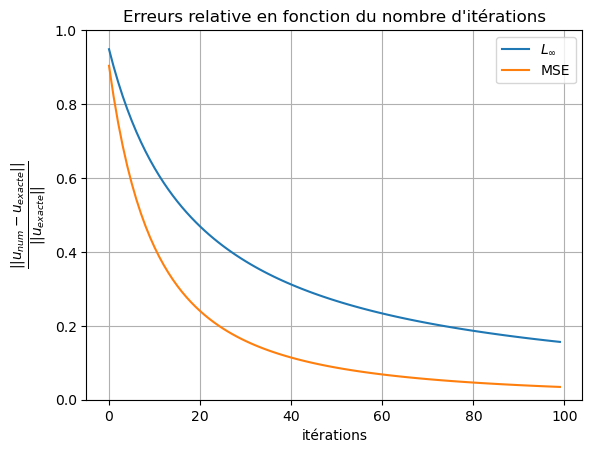

Text(0.5, 1.0, 'Différence Absolue')

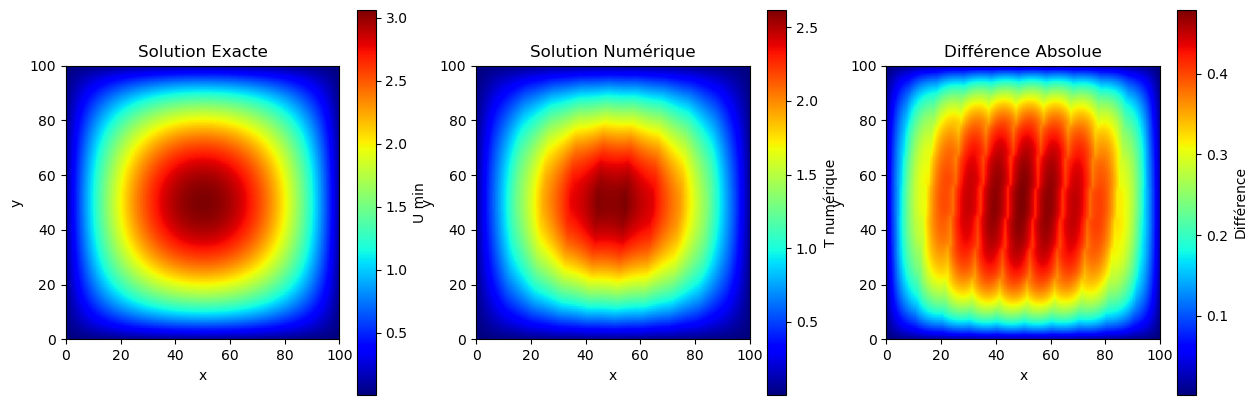

In [25]:
errmax = np.array(errmax)
mse = np.array(mse)

u2D = u.reshape(Nx, Ny)
T2D = T.reshape(Nx, Ny)

# Calcul de la différence
diff = np.abs(u2D - T2D)

plt.plot(np.arange(0, mse.shape[0], 1), errmax, label=r'$L_{\infty}$')
plt.plot(np.arange(0, mse.shape[0], 1), mse, label=r'MSE')
plt.ylim(0, 1)
plt.grid()
plt.xlabel('itérations')
plt.ylabel(r'$\frac{||u_{num} - u_{exacte} ||}{||u_{exacte}||}$', fontsize=14, fontweight='bold')
plt.title("Erreurs relative en fonction du nombre d'itérations")
plt.legend(loc='best')
plt.show()

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5)) # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 2)
plt.imshow(u2D, origin='lower', cmap='jet', extent=[0, len(u2D[0]), 0, len(u2D)])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution du gradient projeté
plt.subplot(1, 3, 1)
plt.imshow(T2D, origin='lower', cmap='jet', extent=[0, len(T2D[0]), 0, len(T2D)])
plt.colorbar(label='U min')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Exacte')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff, origin='lower', cmap='jet', extent=[0, len(diff[0]), 0, len(diff)])
plt.colorbar(label='Différence')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue')